In [74]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [68]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [100]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Data Preprocessing

## load data into list

We first load our data (tiny-imagenet-200 which only has 200 classes), merge all pictures to tensors X_train and X_val, and load the labels for them

In [37]:
#loading training images and labels
train_directory = './tiny-imagenet-200/tiny-imagenet-200/train'
image_list = []
label_list = []
for sub_dir in os.listdir(train_directory):
    sub_dir_name=os.path.join(train_directory,sub_dir)
    sub_dir_name=os.path.join(sub_dir_name,"images")
    #print("Reading folder {}".format(sub_dir))
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        image_list.append(np.array(Image.open(os.path.join(sub_dir_name,file))))
        label_list.append(str(sub_dir))


In [50]:
#loading validation images and labels
val_directory = './tiny-imagenet-200/tiny-imagenet-200/val'
image_list2 = []
val_image_dir = os.path.join(val_directory,"images")
for file in os.listdir(val_image_dir):
    filename = os.fsdecode(file)
    image_list2.append(np.array(Image.open(os.path.join(val_image_dir,file))))
label_list2 = []
val_label_file = os.path.join(val_directory,"val_annotations.txt")
val_df = pd.read_table(val_label_file, header = None, names = ['filename','label','X','Y','H','W'])
label_list2 = val_df['label']


## Visualize some images

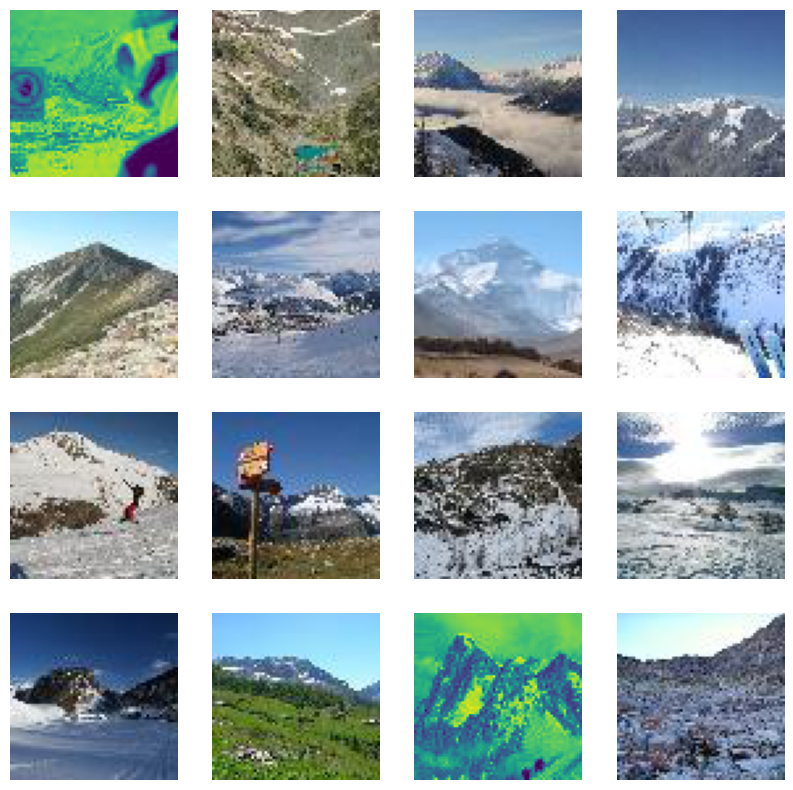

In [28]:
fig = plt.figure(figsize=(10, 10))

for i in range(97240,97256,1):
    ax = fig.add_subplot(4, 4, i+1-97240)
    ax.imshow(image_list[i])
    ax.axis('off')
    

From the images shown above, we can see that some images only have one channel, which means the shape of them is (64,64). Other images have three channel and have a shape of (64,64,3).



## clean data 

In [52]:
single_channel_ind = []
standard_shape = (64,64,3)
for i in range(len(image_list)):
    if(image_list[i].shape!=standard_shape):
        single_channel_ind.append(i)
print("The total number of single channel images in the training images is ",len(single_channel_ind)) 

single_channel_ind2 = []
standard_shape = (64,64,3)
for i in range(len(image_list2)):
    if(image_list2[i].shape!=standard_shape):
        single_channel_ind2.append(i)
print("The total number of single channel images in the validation images is ",len(single_channel_ind2)) 


The total number of single channel images in the training images is  1821
The total number of single channel images in the validation images is  168


As the single channel images only accounts for fewer than 2% of the total data, so we can just eliminate these single channel data.

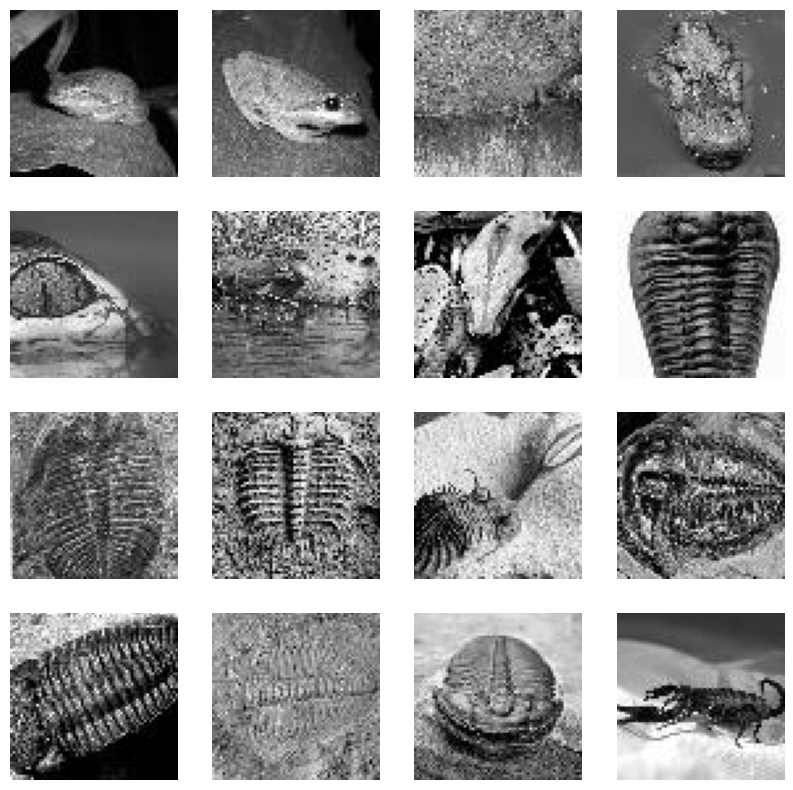

In [53]:
#visualize single channel images
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ind = single_channel_ind[i]
    ax.imshow(image_list[ind],'gray')
    ax.axis('off')

In [88]:
#Method 1: Deleting single channel data 

add_ = int(224-image_list[0].shape[0]/2) 

# the training data processing
three_channel_images = []
clean_label_list = []
for i in range(len(image_list)):
    if(i in single_channel_ind):
        continue
    else:
        #we need resize our images' shape into (224,224,3) to fit mobilenet's input size
        
        #Method 1: Image.resize()
        img = Image.fromarray(image_list[i])
        img = img.resize((224,224),Image.BILINEAR)
        
#         #Method 2: zero padding
#         img = image_list[0]
#         img_pad = np.zeros((224,224,3),dtype = int)
#         for i in range(3):
#             img_pad = np.pad(img[:,:,i],((add_,add_),(add_,add_)),
#                             'constant',constant_values = (0))
        
        three_channel_images.append(np.array(img))
        clean_label_list.append(label_list[i][1:])
        #we need to eliminate the first char 'n', otherwise we will get a ValueError and cannot call tf.one_hot

X_train = np.array(three_channel_images)
y_train = np.array(clean_label_list)
y_train_dummy = tf.one_hot(y_train,depth = 200)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Training labels (one-hot) shape: ', y_train_dummy.shape)

C:\Users\Junkai\AppData\Local\Temp\ipykernel_4820\2595378067.py:16: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((224,224),Image.BILINEAR)


Training data shape:  (98179, 224, 224, 3)
Training labels shape:  (98179,)
Training labels (one-hot) shape:  (98179, 200)


In [90]:
# the validation data processing
three_channel_images2 = []
clean_label_list2 = []
for i in range(len(image_list2)):
    if(i in single_channel_ind2):
        continue
    else:
        #we need resize our images' shape into (224,224,3) to fit mobilenet's input size
        
        #Method 1: Image.resize()
        img = Image.fromarray(image_list2[i])
        img = img.resize((224,224),Image.BILINEAR)
        
#         #Method 2: zero padding
#         img = image_list[0]
#         img_pad = np.zeros((224,224,3),dtype = int)
#         for i in range(3):
#             img_pad = np.pad(img[:,:,i],((add_,add_),(add_,add_)),
#                             'constant',constant_values = (0))
        
        three_channel_images2.append(np.array(img))
        clean_label_list2.append(label_list2[i][1:])
        #we need to eliminate the first char 'n', otherwise we will get a ValueError and cannot call tf.one_hot


X_val = np.array(three_channel_images2)
y_val = np.array(clean_label_list2)
y_val_dummy = tf.one_hot(y_val,depth = 200)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Validation labels (one-hot) shape: ', y_val_dummy.shape)

C:\Users\Junkai\AppData\Local\Temp\ipykernel_4820\638492614.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((224,224),Image.BILINEAR)


Validation data shape:  (9832, 224, 224, 3)
Validation labels shape:  (9832,)
Validation labels (one-hot) shape:  (9832, 200)


In [ ]:
#Method 2: generate some noise for single channel data to work as the other channels

#noise 1: zero matrix, so that the convolution will learn nothing from those channel that doesn't exist

#noise 2: normal noise, noise follows a normal distribution

#noise 3: uniform noise, noise follows a uniform distribution


In [ ]:
#Method 3: generate data for the other channels

#Method 3.1: using the single channel data itself for 3 times

#Method 3.2: using the mean matrix of the other data with the same class

# Deploying the mobilenet model and test it

In [93]:
model = MobileNet(include_top = False, classes = 200)
x = model.output
x = GlobalAveragePooling2D()(x)
preds=Dense(200,activation='softmax')(x)


In [95]:
model2=Model(inputs=model.input,outputs=preds)

In [97]:
model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, None, None, 512)  4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_pw_9 (Conv2D)          (None, None, None, 512)   262144    
                                                                 
 conv_pw_9

In [99]:
model2.fit(x = X_train,y = y_train_dummy,batch_size = 64,
           epochs = 15,validation_data=(X_val,y_val_dummy))

Epoch 1/15
  10/1535 [..............................] - ETA: 1:28:24 - loss: 0.0000e+00 - accuracy: 0.0000e+00

KeyboardInterrupt: 